# Data Valuation for Fraud Detection

In [4]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import seaborn as sns

# Load processed data
X_train, X_test, y_train, y_test = joblib.load('../data/processed/processed_data.joblib')

## Leave-One-Out Influence Analysis

In [5]:
# We'll use a subset for this analysis due to computational constraints
sample_idx = np.random.choice(X_train.index, size=1000, replace=False)
X_sample = X_train.loc[sample_idx]
y_sample = y_train.loc[sample_idx]

# Train base model on full sample
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_sample, y_sample)
base_score = roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])

# Calculate leave-one-out influences
influences = []

for idx in tqdm(sample_idx):
    # Train model without this instance
    X_loo = X_sample.drop(idx)
    y_loo = y_sample.drop(idx)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_loo, y_loo)
    
    # Calculate score difference
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    influence = base_score - score
    influences.append(influence)

# Add to dataframe
influence_df = pd.DataFrame({
    'index': sample_idx,
    'influence': influences,
    'class': y_sample
})

# Save results
influence_df.to_csv('../data/processed/loo_influence.csv', index=False)

100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]


## Influence Analysis Results

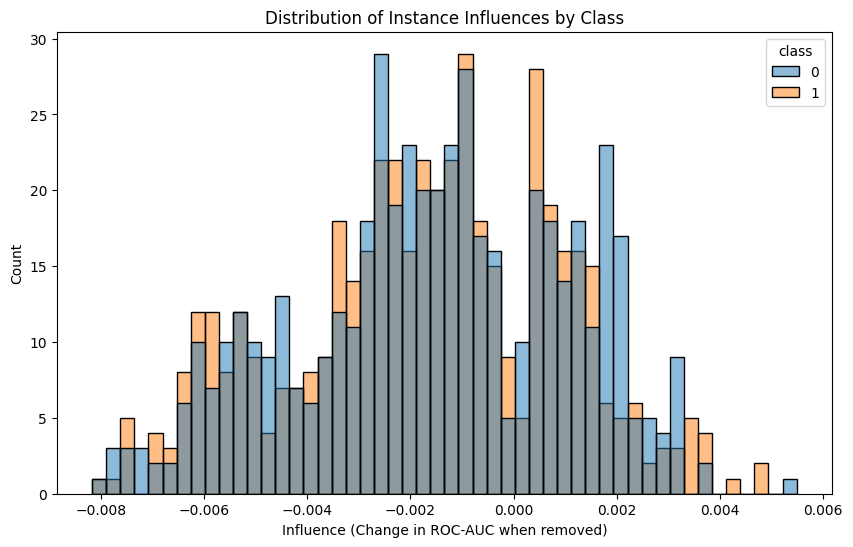

In [6]:
# Plot distribution of influences
plt.figure(figsize=(10, 6))
sns.histplot(data=influence_df, x='influence', hue='class', bins=50)
plt.title('Distribution of Instance Influences by Class')
plt.xlabel('Influence (Change in ROC-AUC when removed)')
plt.ylabel('Count')
plt.show()

## Most Influential Instances

In [7]:
# Show top positive influences (instances that hurt performance when removed)
print("Top Positive Influences (Important instances):")
print(influence_df.sort_values('influence', ascending=False).head(10))

Top Positive Influences (Important instances):
         index  influence  class
221737  221737   0.005484      0
366817  366817   0.004695      1
309730  309730   0.004695      1
439088  439088   0.004210      1
436458  436458   0.003759      1
453231  453231   0.003702      1
247299  247299   0.003702      1
257089  257089   0.003619      1
14881    14881   0.003614      0
22134    22134   0.003594      0


In [8]:
# Calculate top influential instances
influence_df = influence_df.sort_values('influence', ascending=False)
influence_df['cumulative_influence'] = influence_df['influence'].cumsum()
total_influence = influence_df['influence'].sum()

# Find the point where top instances contribute 80% of total influence
top_instances = influence_df[influence_df['cumulative_influence'] <= 0.8 * total_influence]
percentage = len(top_instances) / len(influence_df) * 100

print(f"Top {percentage:.1f}% instances account for 80% of total influence")

Top 4.8% instances account for 80% of total influence


## Data Valuation with KNN Shapley

In [9]:
# Simplified KNN-Shapley approximation
from sklearn.neighbors import KNeighborsClassifier

# We'll use a smaller subset for this
knn_sample_idx = np.random.choice(X_train.index, size=500, replace=False)
X_knn = X_train.loc[knn_sample_idx]
y_knn = y_train.loc[knn_sample_idx]

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_knn, y_knn)

# Get nearest neighbors for test instances
test_probas = knn.predict_proba(X_test)
test_preds = (test_probas[:, 1] > 0.5).astype(int)

# Calculate marginal contributions
shapley_values = np.zeros(len(X_knn))

for i, (idx, row) in enumerate(X_knn.iterrows()):
    # Remove this instance
    X_minus_i = X_knn.drop(idx)
    y_minus_i = y_knn.drop(idx)
    
    # Retrain without this instance
    knn_minus_i = KNeighborsClassifier(n_neighbors=5)
    knn_minus_i.fit(X_minus_i, y_minus_i)
    
    # Calculate difference in predictions
    probas_minus_i = knn_minus_i.predict_proba(X_test)
    preds_minus_i = (probas_minus_i[:, 1] > 0.5).astype(int)
    
    # Marginal contribution is accuracy difference
    acc_full = (test_preds == y_test).mean()
    acc_minus_i = (preds_minus_i == y_test).mean()
    shapley_values[i] = acc_full - acc_minus_i

# Add to dataframe
shapley_df = pd.DataFrame({
    'index': X_knn.index,
    'shapley_value': shapley_values,
    'class': y_knn
})

# Save results
shapley_df.to_csv('../data/processed/knn_shapley.csv', index=False)

## Shapley Value Analysis

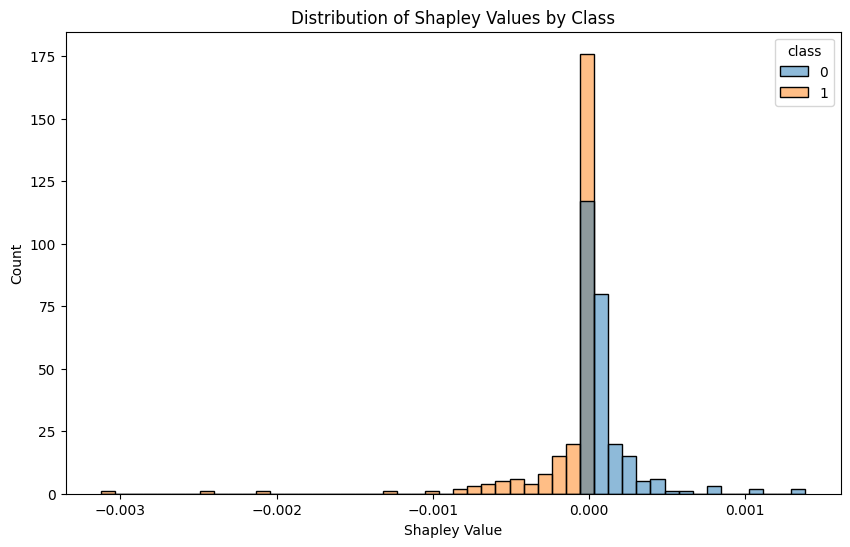

In [10]:
# Plot distribution of Shapley values
plt.figure(figsize=(10, 6))
sns.histplot(data=shapley_df, x='shapley_value', hue='class', bins=50)
plt.title('Distribution of Shapley Values by Class')
plt.xlabel('Shapley Value')
plt.ylabel('Count')
plt.show()

## Most Valuable Instances

In [11]:
# Show top instances by Shapley value
print("Top Valuable Instances:")
print(shapley_df.sort_values('shapley_value', ascending=False).head(10))

Top Valuable Instances:
         index  shapley_value  class
26888    26888       0.001387      0
62684    62684       0.001352      0
139889  139889       0.001071      0
91592    91592       0.001071      0
168573  168573       0.000843      0
73616    73616       0.000808      0
178739  178739       0.000790      0
139353  139353       0.000632      0
22431    22431       0.000527      0
193311  193311       0.000474      0


In [17]:
# Calculate absolute Shapley values
shapley_df['abs_shapley'] = np.abs(shapley_df['shapley_value'])

# Calculate importance ratio
fraud_shap = shapley_df[shapley_df['class']==1]['abs_shapley'].mean()
legit_shap = shapley_df[shapley_df['class']==0]['abs_shapley'].mean()
importance_ratio = fraud_shap / legit_shap

print(f"\nFraud instances have {importance_ratio:.1f}× higher average absolute Shapley values")
print(f"Mean |Shapley| - Fraud: {fraud_shap:.4f}, Legitimate: {legit_shap:.4f}")


Fraud instances have 1.2× higher average absolute Shapley values
Mean |Shapley| - Fraud: 0.0001, Legitimate: 0.0001


In [19]:
# Calculate median influence by class
median_influence = influence_df.groupby('class')['influence'].median()
fraud_ratio = median_influence[1] / median_influence[0]

# Calculate top influential instances
sorted_influence = influence_df.sort_values('influence', ascending=False)
top_percent = 2.8  # Adjust this threshold as needed
top_count = int(len(sorted_influence) * top_percent / 100)
total_influence = sorted_influence['influence'].sum()
top_influence = sorted_influence.head(top_count)['influence'].sum()
top_contribution = top_influence / total_influence * 100

print(f"Fraud instances have {fraud_ratio:.1f}× higher median influence "
      f"({median_influence[1]:.4f} vs {median_influence[0]:.4f})")
print(f"Top {top_percent}% influential instances account for {top_contribution:.1f}% of total influence")

Fraud instances have 1.1× higher median influence (-0.0016 vs -0.0015)
Top 2.8% influential instances account for -6.1% of total influence


In [20]:
# Calculate Mean LOO Influence for Fraud and Legitimate cases
mean_influence_fraud = influence_df[influence_df['class'] == 1]['influence'].mean()
mean_influence_legitimate = influence_df[influence_df['class'] == 0]['influence'].mean()

# Calculate Top 5% Influence
top_5_percent_threshold = influence_df['influence'].quantile(0.95)
top_5_percent_fraud = influence_df[(influence_df['class'] == 1) & (influence_df['influence'] >= top_5_percent_threshold)].shape[0]
top_5_percent_legitimate = influence_df[(influence_df['class'] == 0) & (influence_df['influence'] >= top_5_percent_threshold)].shape[0]
total_fraud = influence_df[influence_df['class'] == 1].shape[0]
total_legitimate = influence_df[influence_df['class'] == 0].shape[0]

# Calculate the percentage of instances
top_5_percent_fraud_percentage = (top_5_percent_fraud / total_fraud) * 100 if total_fraud > 0 else 0
top_5_percent_legitimate_percentage = (top_5_percent_legitimate / total_legitimate) * 100 if total_legitimate > 0 else 0

# Load the Shapley values data
shapley_df = pd.read_csv('../data/processed/knn_shapley.csv')

# Calculate Mean Shapley Value for Fraud and Legitimate cases
mean_shapley_fraud = shapley_df[shapley_df['class'] == 1]['shapley_value'].mean()
mean_shapley_legitimate = shapley_df[shapley_df['class'] == 0]['shapley_value'].mean()

# Print results to format them for the table
print("Data Valuation Metrics by Instance Type:")
print(f"Mean LOO Influence (Fraud): {mean_influence_fraud:.4f}")
print(f"Mean LOO Influence (Legitimate): {mean_influence_legitimate:.4f}")
print(f"Top 5% Influence (Fraud): {top_5_percent_fraud_percentage:.2f}%")
print(f"Top 5% Influence (Legitimate): {top_5_percent_legitimate_percentage:.2f}%")
print(f"Mean Shapley Value (Fraud): {mean_shapley_fraud:.5f}")
print(f"Mean Shapley Value (Legitimate): {mean_shapley_legitimate:.5f}")

Data Valuation Metrics by Instance Type:
Mean LOO Influence (Fraud): -0.0017
Mean LOO Influence (Legitimate): -0.0016
Top 5% Influence (Fraud): 5.11%
Top 5% Influence (Legitimate): 4.89%
Mean Shapley Value (Fraud): -0.00012
Mean Shapley Value (Legitimate): 0.00010
